### Test of stationarity

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

In [2]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=12,center=False).mean()
#     rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [3]:
datasets = pd.read_excel('TB_nation.xlsx',index_col='Date')
datasets_pred = datasets[datasets.index>='2014-01-1']
datasets = datasets[datasets.index<'2014-01-01']
datasets.shape

(120, 7)

In [8]:
datasets.head()

,Area,Incidence,Death,Incidence_rate,Death_rate,Year,Month
Date,,,,,,,
2004-01-01,全 国,99466,67,7.651937,0.005154,2004,1
2004-02-01,全 国,84156,68,6.474136,0.005231,2004,2
2004-03-01,全 国,94360,111,7.259132,0.008539,2004,3
2004-04-01,全 国,91944,121,7.073268,0.009309,2004,4
2004-05-01,全 国,90379,151,6.952873,0.011616,2004,5


In [9]:
datasets.describe()

,Incidence,Death,Incidence_rate,Death_rate,Year,Month
count,120.000000,120.00000,120.000000,120.000000,120.000000,120.000000
mean,88068.025000,245.90000,6.655797,0.018566,2008.500000,6.500000
std,18910.537604,77.37146,1.470027,0.005904,2.884324,3.466527
min,37257.000000,67.00000,2.866188,0.005154,2004.000000,1.000000
25%,75721.500000,202.75000,5.630322,0.015193,2006.000000,3.750000
50%,87800.500000,242.50000,6.644592,0.018062,2008.500000,6.500000
75%,98984.500000,293.00000,7.501241,0.022147,2011.000000,9.250000
max,133924.000000,433.00000,10.302798,0.032605,2013.000000,12.000000


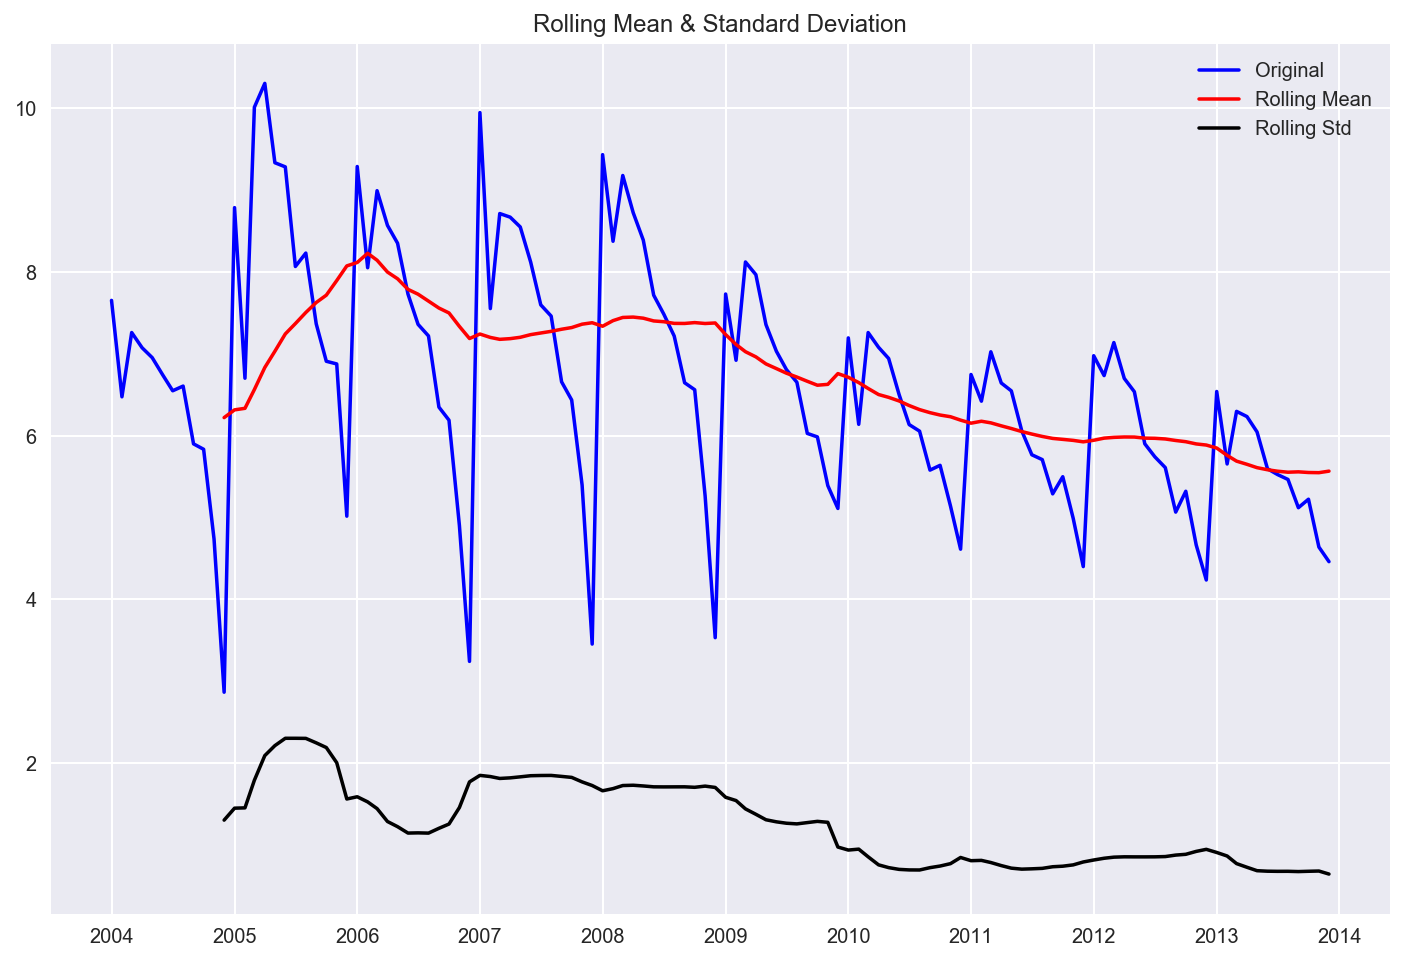

Results of Dickey-Fuller Test:
Test Statistic                  -0.851396
p-value                          0.803557
#Lags Used                      12.000000
Number of Observations Used    107.000000
Critical Value (10%)            -2.581393
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
dtype: float64


In [10]:
test_stationarity(datasets.Incidence_rate)

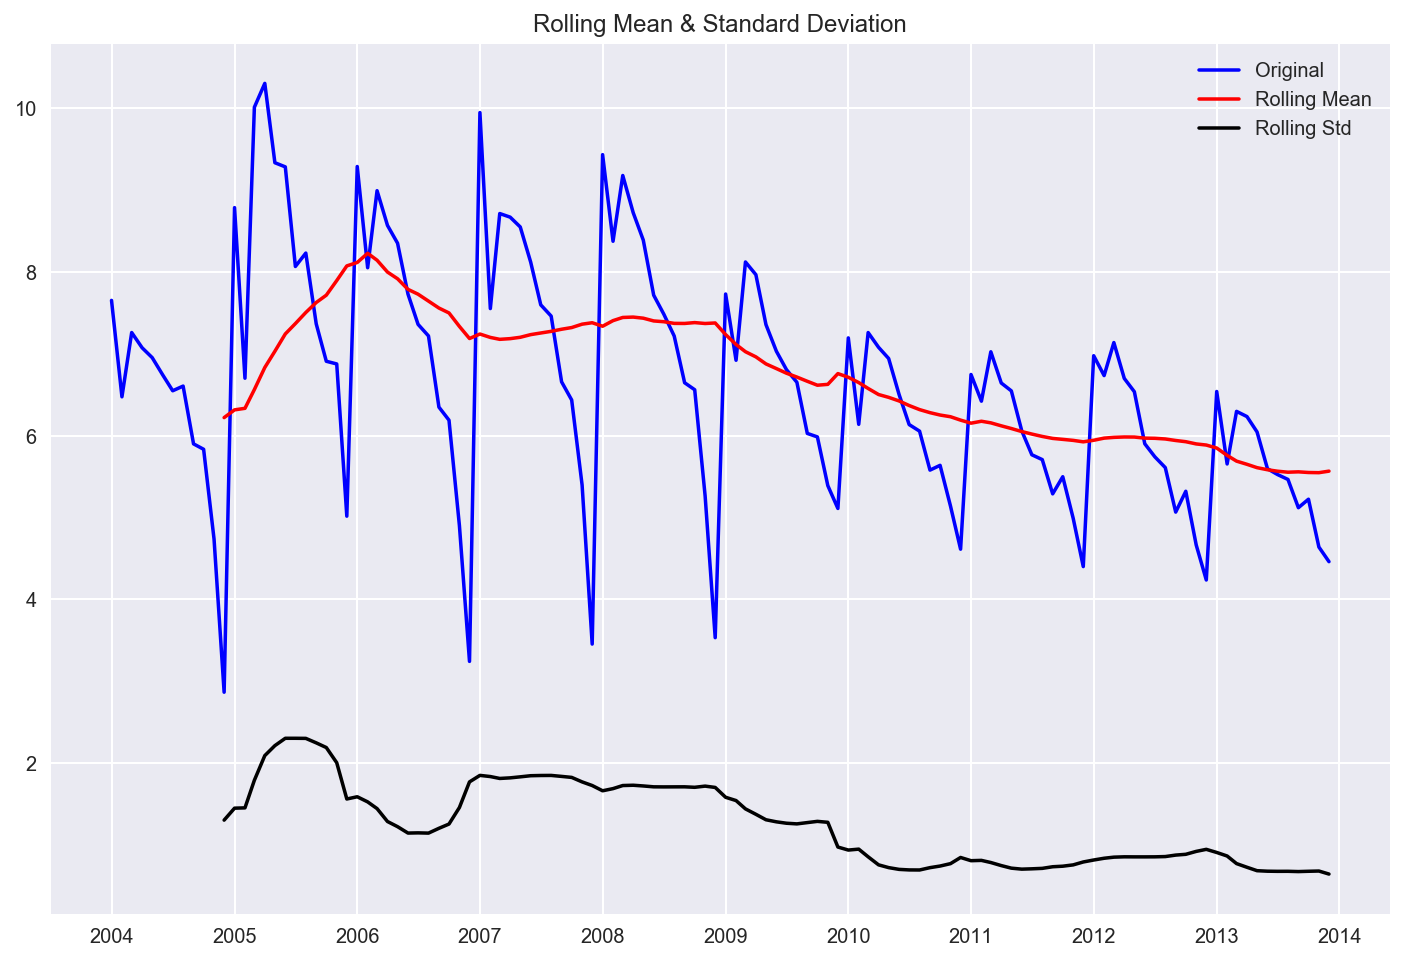

Results of Dickey-Fuller Test:
Test Statistic                  -0.851396
p-value                          0.803557
#Lags Used                      12.000000
Number of Observations Used    107.000000
Critical Value (10%)            -2.581393
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
dtype: float64


In [11]:
test_stationarity(datasets['Incidence_rate'])

### First difference

In [ ]:
datasets['first_diff'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(1)
test_stationarity(datasets.first_diff.dropna(inplace=False))

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.first_diff.iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.first_diff.iloc[1:], lags=40, ax=ax2)

### Seasonal difference

In [ ]:
datasets['seasonal_difference'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(12)  
test_stationarity(datasets.seasonal_difference.dropna(inplace=False))

### Seasonal first difference 

In [ ]:
datasets['seasonal_first_difference'] = datasets.first_diff-datasets.first_diff.shift(12)
test_stationarity(datasets.seasonal_first_difference.dropna(inplace=False))

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.seasonal_first_difference.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

### Bulid Model

In [ ]:
mod = sm.tsa.SARIMAX(datasets.Incidence_rate, trend='n', order=(0,1,2), seasonal_order=(0,1,1,12))
results = mod.fit()
print(results.summary())

### Plot

In [ ]:
datasets['forecast'] = results.predict(start = 13, end= 131, dynamic= False)  
datasets[['Incidence_rate', 'forecast']].plot(figsize=(12, 8))

In [ ]:
npredict =datasets.Incidence_rate['2004'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='National TB', xlabel='Date', ylabel='Riders')
ax.plot(datasets.index[-npredict-npre+1:], datasets.ix[-npredict-npre+1:, 'Incidence_rate'], 'o', label='Observed')
ax.plot(datasets.index[-npredict-npre+1:], datasets.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')

In [ ]:
dta = pd.concat([datasets, datasets_pred])[['Death','Death_rate','Incidence','Incidence_rate','forecast','Year','Month']]
dta['forecast'] = results.predict(start=13,end=131,dynamic=False)
dta.tail(13)

In [ ]:
dta['forecast'] = results.predict(start = 13, end= 131, dynamic= False)  
dta[['Incidence_rate','forecast']].plot(figsize=(12, 8))

In [ ]:
dta['error_ARIMA'] = dta['forecast']-dta['Incidence_rate']
dta['error_ARIMA'] .plot(figsize=(12,8))
sum(dta['error_ARIMA'].dropna())

In [ ]:
dta.to_excel('data_SARIMA.xlsx')